In [1]:
from qiskit.transpiler.passes import SetLayout, ApplyLayout
from qiskit.transpiler.passes import SabreSwap, TrivialLayout, CheckMap
from qiskit.transpiler import CouplingMap, Layout, PassManager

from qibo.cskim_utils.circuit_info import count_gates_qibo, count_swaps_qibo
from qibo.transpiler.pipeline import Passes
from qibo.transpiler.placer import Trivial
from qibo.transpiler.router import Sabre

from qibo.cskim_utils.circuit_info import count_gates_qiskit, count_swaps_qiskit

from qiskit import QuantumCircuit
from qibo import gates


In [32]:
def sabre_qiskit(cmap, circuit, verbose=False):
    """
    Transpile a circuit using only Sabre transpiler from Qiskit.
    """
    if verbose:
        print("swaps before transpiling", count_swaps_qiskit(circuit))
        print("gates before transpiling", count_gates_qiskit(circuit))

    q = circuit.qubits
    nqubits = len(q)

    pass_manager = PassManager()
    pass_manager.append(
        SetLayout(Layout({q[i]: i for i in range(nqubits)})))
    pass_manager.append(ApplyLayout())
    pass_manager.append(SabreSwap(coup, "decay"))
    new_qc = pass_manager.run(circuit)

    if verbose:
        display(new_qc.draw(fold=-1))
        print("swaps after transpiling", count_swaps_qiskit(new_qc))
        print("gates after transpiling", count_gates_qiskit(new_qc))
    
    added_swaps =  count_swaps_qiskit(new_qc) - count_swaps_qiskit(circuit)
    
    if verbose:
        print("added swaps", added_swaps)
    
    return added_swaps

def sabre_qibo(conn, circuit, verbose=False):
    """
    Transpile a circuit using only Sabre transpiler from Qibo.
    """
    if verbose:
        print("swaps before transpiling", count_swaps_qibo(circuit))
        print("gates before transpiling", count_gates_qibo(circuit))

    custom_passes = [Trivial(connectivity=conn), Sabre(connectivity=conn)]
    custom_pipeline = Passes(custom_passes, connectivity=conn)
    transpiled_circ, final_layout = custom_pipeline(circuit)

    if verbose:
        print(transpiled_circ.draw(line_wrap=1000))
        print("swaps after transpiling", count_swaps_qibo(transpiled_circ))
        print("gates after transpiling", count_gates_qibo(transpiled_circ))
    
    added_swaps =  count_swaps_qibo(transpiled_circ) - count_swaps_qibo(circuit)
    
    if verbose:
        print("added swaps", added_swaps)

    return added_swaps

def qibo_to_qiskit_cz(circuit):
    qiskit_circuit = QuantumCircuit(circuit.nqubits)
    for gate in circuit.queue:
        if isinstance(gate, gates.CZ):
            qiskit_circuit.cz(gate.qubits[0], gate.qubits[1])
    return qiskit_circuit


In [3]:
nqubits = 10

In [4]:
from qibo.cskim_utils.connectivity import complete_connectivity_cmap, complete_connectivity_nx
from qibo.cskim_utils.connectivity import cycle_connectivity_cmap, cycle_connectivity_nx
from qibo.cskim_utils.connectivity import line_connectivity_cmap, line_connectivity_nx

from qibo.cskim_utils.gen_circuit import random_control_circuit_qibo
from matplotlib import pyplot as plt

from qibo.cskim_utils.gen_circuit import qiskit_qft
from qibo.models.qft import QFT

## QFT

In [13]:
nqubits = 10
qft_circ_qibo = QFT(nqubits)
qft_circ_qiskit = qiskit_qft(nqubits)

# Line connectivity
conn = line_connectivity_nx(nqubits)
cmap = line_connectivity_cmap(nqubits)
coup = CouplingMap(couplinglist=cmap)

nswap_line_qiskit = sabre_qiskit(coup, qft_circ_qiskit, False)
nswap_line_qibo = sabre_qibo(conn, qft_circ_qibo, False)

print("added_swap_line_qiskit", nswap_line_qiskit)
print("added_swap_line_qibo", nswap_line_qibo)

# Cycle connectivity
conn = cycle_connectivity_nx(nqubits)
cmap = cycle_connectivity_cmap(nqubits)
coup = CouplingMap(couplinglist=cmap)

nswap_cycle_qiskit = sabre_qiskit(coup, qft_circ_qiskit, False)
nswap_cycle_qibo = sabre_qibo(conn, qft_circ_qibo, False)

print("\nadded_swap_cycle_qiskit", nswap_cycle_qiskit)
print("added_swap_cycle_qibo", nswap_cycle_qibo)

# Complete connectivity
conn = complete_connectivity_nx(nqubits)
cmap = complete_connectivity_cmap(nqubits)
coup = CouplingMap(couplinglist=cmap)

nswap_complete_qiskit = sabre_qiskit(coup, qft_circ_qiskit, False)
nswap_complete_qibo = sabre_qibo(conn, qft_circ_qibo, False)

print("\nadded_swap_complete_qiskit", nswap_complete_qiskit)
print("added_swap_complete_qibo", nswap_complete_qibo)

added_swap_line_qiskit 65
added_swap_line_qibo 60

added_swap_cycle_qiskit 53
added_swap_cycle_qibo 46

added_swap_complete_qiskit 0
added_swap_complete_qibo 0


## Random Circuit

### Line graph

Avg #SWAPs, line connectivity, Qibo: 34.43
Avg #SWAPs, line connectivity, Qiskit: 33.3

Min #SWAPs, line connectivity, Qibo: 21
Min #SWAPs, line connectivity, Qiskit: 22


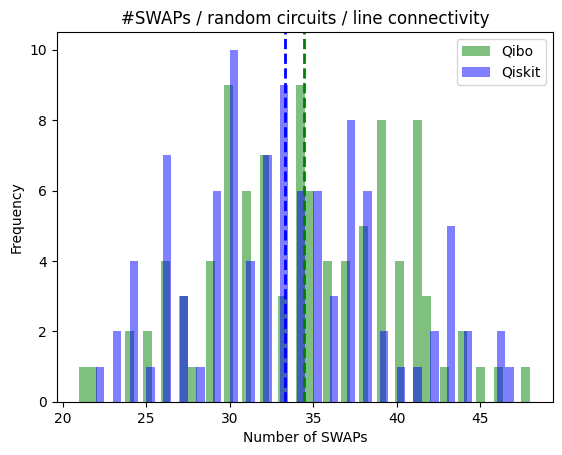

In [23]:
ncz_qibo_line = []
ncz_qiskit_line = []
repeat = 100

conn = line_connectivity_nx(nqubits)
cmap = line_connectivity_cmap(nqubits)
coup = CouplingMap(couplinglist=cmap)

for i in range(repeat):
    random_circ_qibo = random_control_circuit_qibo(10, 20)
    random_circ_qiskit = qibo_to_qiskit_cz(random_circ_qibo)

    nqiskit = sabre_qiskit(cmap, random_circ_qiskit, False)
    nqibo = sabre_qibo(conn, random_circ_qibo, False)

    ncz_qibo_line.append(nqibo)
    ncz_qiskit_line.append(nqiskit)

print("Avg #SWAPs, line connectivity, Qibo:", sum(ncz_qibo_line)/repeat)
print("Avg #SWAPs, line connectivity, Qiskit:", sum(ncz_qiskit_line)/repeat)
print()
print("Min #SWAPs, line connectivity, Qibo:", min(ncz_qibo_line))
print("Min #SWAPs, line connectivity, Qiskit:", min(ncz_qiskit_line))

plt.hist(ncz_qibo_line, bins=50, color='g', label='Qibo', alpha=0.5)
plt.hist(ncz_qiskit_line, bins=50, color='b', label='Qiskit', alpha=0.5)
plt.axvline(sum(ncz_qibo_line)/repeat, color='g', linestyle='dashed', linewidth=2)
plt.axvline(sum(ncz_qiskit_line)/repeat, color='b', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel("Number of SWAPs")
plt.ylabel("Frequency")
plt.title("#SWAPs / random circuits / line connectivity")
plt.show()

### Complete graph

Avg #SWAPs, complete connectivity, Qibo: 0.0
Avg #SWAPs, complete connectivity, Qiskit: 0.0

Min #SWAPs, complete connectivity, Qibo: 0
Min #SWAPs, complete connectivity, Qiskit: 0


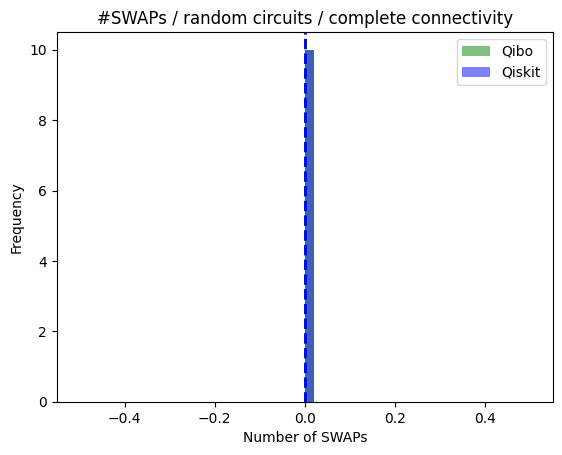

In [24]:
ncz_qibo_complete = []
ncz_qiskit_complete = []
repeat = 10

conn = complete_connectivity_nx(nqubits)
cmap = complete_connectivity_cmap(nqubits)
coup = CouplingMap(couplinglist=cmap)

for i in range(repeat):

    random_circ_qibo = random_control_circuit_qibo(10, 50)
    random_circ_qiskit = qibo_to_qiskit_cz(random_circ_qibo)

    nqiskit = sabre_qiskit(cmap, random_circ_qiskit, False)
    nqibo = sabre_qibo(conn, random_circ_qibo, False)

    ncz_qibo_complete.append(nqibo)
    ncz_qiskit_complete.append(nqiskit)

print("Avg #SWAPs, complete connectivity, Qibo:", sum(ncz_qibo_complete)/repeat)
print("Avg #SWAPs, complete connectivity, Qiskit:", sum(ncz_qiskit_complete)/repeat)
print()
print("Min #SWAPs, complete connectivity, Qibo:", min(ncz_qibo_complete))
print("Min #SWAPs, complete connectivity, Qiskit:", min(ncz_qiskit_complete))

plt.hist(ncz_qibo_complete, bins=50, color='g', label='Qibo', alpha=0.5)
plt.hist(ncz_qiskit_complete, bins=50, color='b', label='Qiskit', alpha=0.5)
plt.axvline(sum(ncz_qibo_complete)/repeat, color='g', linestyle='dashed', linewidth=2)
plt.axvline(sum(ncz_qiskit_complete)/repeat, color='b', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel("Number of SWAPs")
plt.ylabel("Frequency")
plt.title("#SWAPs / random circuits / complete connectivity")
plt.show()

### Cycle graph

Avg #SWAPs, cycle connectivity, Qibo: 57.4
Avg #SWAPs, cycle connectivity, Qiskit: 57.76

Min #SWAPs, cycle connectivity, Qibo: 42
Min #SWAPs, cycle connectivity, Qiskit: 44


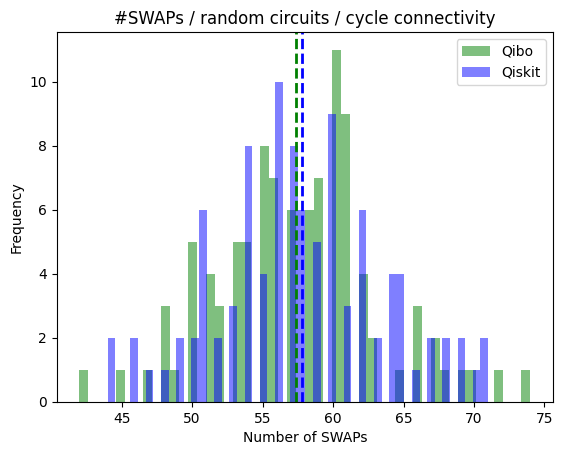

In [29]:
ncz_qibo_cycle = []
ncz_qiskit_cycle = []
repeat = 100

conn = cycle_connectivity_nx(nqubits)
cmap = cycle_connectivity_cmap(nqubits)
coup = CouplingMap(couplinglist=cmap)

for i in range(repeat):

    random_circ_qibo = random_control_circuit_qibo(10, 50)
    random_circ_qiskit = qibo_to_qiskit_cz(random_circ_qibo)

    nqiskit = sabre_qiskit(coup, random_circ_qiskit, False)
    nqibo = sabre_qibo(conn, random_circ_qibo, False)

    ncz_qibo_cycle.append(nqibo)
    ncz_qiskit_cycle.append(nqiskit)

print("Avg #SWAPs, cycle connectivity, Qibo:", sum(ncz_qibo_cycle)/repeat)
print("Avg #SWAPs, cycle connectivity, Qiskit:", sum(ncz_qiskit_cycle)/repeat)
print()
print("Min #SWAPs, cycle connectivity, Qibo:", min(ncz_qibo_cycle))
print("Min #SWAPs, cycle connectivity, Qiskit:", min(ncz_qiskit_cycle))

plt.hist(ncz_qibo_cycle, bins=50, color='g', label='Qibo', alpha=0.5)
plt.hist(ncz_qiskit_cycle, bins=50, color='b', label='Qiskit', alpha=0.5)
plt.axvline(sum(ncz_qibo_cycle)/repeat, color='g', linestyle='dashed', linewidth=2)
plt.axvline(sum(ncz_qiskit_cycle)/repeat, color='b', linestyle='dashed', linewidth=2)
plt.legend()
plt.xlabel("Number of SWAPs")
plt.ylabel("Frequency")
plt.title("#SWAPs / random circuits / cycle connectivity")
plt.show()

# Anomaly

In [17]:
from qibo.models.circuit import Circuit

qubit_array = [(9, 8), (0, 6), (8, 4), (1, 2), (3, 6), 
               (2, 4), (3, 8), (6, 2), (0, 4), (0, 6), 
               (4, 1), (7, 2), (6, 0), (5, 6), (4, 8), 
               (3, 5), (3, 4), (9, 1), (1, 6), (9, 6)]
ano_circ = Circuit(nqubits)

for qubit in qubit_array:
    ano_circ.add(gates.CZ(*qubit))

print(ano_circ.draw(line_wrap=1000))

q0: ───o─────────────o─o─────Z───────────────
q1: ───|───o─────────|─|─Z───|─────────Z─o───
q2: ───|───Z───o───Z─|─|─|─Z─|─────────|─|───
q3: ───|─────o─|─o─|─|─|─|─|─|─────o─o─|─|───
q4: ───|─Z───|─Z─|─|─Z─|─o─|─|───o─|─Z─|─|───
q5: ───|─|───|───|─|───|───|─|─o─|─Z───|─|───
q6: ───Z─|───Z───|─o───Z───|─o─Z─|─────|─Z─Z─
q7: ─────|───────|─────────o─────|─────|───|─
q8: ─Z───o───────Z───────────────Z─────|───|─
q9: ─o─────────────────────────────────o───o─


In [33]:
conn = line_connectivity_nx(nqubits)
cmap = line_connectivity_cmap(nqubits)
coup = CouplingMap(couplinglist=cmap)

ano_circ_qiskit = qibo_to_qiskit_cz(ano_circ)

print("=========================================")
print("Qibo - Abnormal")
nqibo = sabre_qibo(conn, ano_circ, True)


print("\n\n=========================================")
print("Qiskit - Normal")
nqiskit = sabre_qiskit(coup, ano_circ_qiskit, True)


Qibo - Abnormal
swaps before transpiling 0
gates before transpiling 20
q0: ───────────────────────x─────────x─────────────────────────x─────────x─────x───x───x─────────────x─────x───x─────────────x─────────────────────────────────────────────────────x───────────────x───────────x───────────x─────────────────────────────────────────────────────o─x───
q1: ───o───────────────────x─o─────o─x─Z─────x───────────────x─x─x───x───x───x─x───x───x───────x─────x───x─x───x───x───────x─x─x───x───────x───x─────x───────x───────────x─────x───x───────────────x─x───x─────x───────────x─────────────────────────────────────────────────x───Z─x─o─
q2: ───Z───────────────x─────Z───x─Z───o─────x─────────────x─x───x───x───────x─────────────────x─────────x─────────x─────x─x───x─x─x─────x─x─x─x───x─x─x─────x─────x─────x─x───x─────────────x───────x─x─x─x─────────────x───────────────────────────────x───────────────x───x─o─────Z─
q3: ─────────x─────────x─o─────x─x─────────────x─────Z─────x─────────────────────────────

q_0 -> 0 ────────────────■─────────────────■───────────■──■────────────────────────────
                         │                 │           │  │                            
q_1 -> 1 ─■───────────X──■──X───────────X──■──■─────X──■──■──X─────X───────────────────
          │           │     │           │     │     │        │     │                   
q_2 -> 2 ─■────────X──X─────X──■─────X──X─────■──X──X──■─────X──X──X──────────────■────
                   │           │     │           │     │        │                 │    
q_3 -> 3 ───────X──X──X────────■──X──X──■────────X──X──■────────X──■─────X─────X──■────
                │     │           │     │           │              │     │     │       
q_4 -> 4 ────X──X─────X──■──X─────X──X──■──X─────X──X──X───────────■──■──X──X──X───────
             │           │  │        │     │     │     │              │     │          
q_5 -> 5 ─X──X─────■─────■──X────────X──■──X──X──X──X──X──X───────────■─────X──■─────■─
          │        │                    │     │     │     │                    │     │ 
q_6 -> 6 ─X─────X──■────────────────────■─────X──X──X─────X──■─────────────────■──X──■─
                │                                │           │                    │    
q_7 -> 7 ────X──X────────────────────────────────X──■─────X──■────────────────────X────
             │                                      │     │                            
q_8 -> 8 ─■──X──────────────────────────────────────■──X──X────────────────────────────
          │                                            │                               
q_9 -> 9 ─■────────────────────────────────────────────X───────────────────────────────

swaps after transpiling 33
gates after transpiling 53
added swaps 33


In [36]:
# print("added_swap / abnormal_qibo", nqibo)
# print("added_swap / normal_qiskit", nqiskit)

print("Qibo(Abnormal) added swaps:", nqibo)
print("Qiskit(Normal) added swaps:", nqiskit)

Qibo(Abnormal) added swaps: 117
Qiskit(Normal) added swaps: 33
